# <div style="background-color:#2e86c1;padding:20px;border-radius:10px">
# <h1 style="color:white;text-align:center">Advanced Alpha Decay Monitoring System</h1>
# <h3 style="color:white;text-align:center">Quantitative Framework for Excess Return Erosion Detection</h3>
# </div>
# 
# ## 1. Theoretical Framework
# 
# ### 1.1 The Concept of Alpha in Finance
# 
# Alpha (α) represents the excess return of an investment relative to a benchmark's performance. It quantifies the value added by active portfolio management:
# 
# $$\alpha = R_p - [R_f + \beta (R_m - R_f)]$$
# 
# Where:
# - $R_p$ = Portfolio return
# - $R_f$ = Risk-free rate
# - $\beta$ = Portfolio's market sensitivity (systematic risk)
# - $R_m$ = Market return
# 
# ### 1.2 Alpha Decay: Mathematical Model
# 
# Alpha decay follows a stochastic process modeled as:
# 
# $$d\alpha_t = \mu(\alpha_t)dt + \sigma(\alpha_t)dW_t$$
# 
# Where:
# - $\mu(\alpha_t)$ = Systematic drift component
# - $\sigma(\alpha_t)$ = Volatility of alpha
# - $dW_t$ = Wiener process (random market shocks)
# 
# ### 1.3 Detection Methodology
# 
# We implement a dual detection framework:
# 
# **a) Threshold Hypothesis Test:**
# $$\begin{cases}
# H_0: \alpha \geq \alpha_{\text{threshold}} & \text{(No decay)} \\
# H_1: \alpha < \alpha_{\text{threshold}} & \text{(Decay detected)}
# \end{cases}$$
# 
# **b) Trend Regression:**
# $$\alpha_t = \beta_0 + \beta_1 t + \epsilon_t$$
# 
# We reject $H_0$ if:
# 1. $\beta_1 < 0$ (Negative slope)
# 2. $p\text{-value} < 0.05$ (Statistically significant)
# 3. $R^2 > 0.7$ (Strong explanatory power)
# 
# ### 1.4 Statistical Process Control
# 
# We monitor alpha using control charts with three zones:
# 
# ```plaintext
# |--------------------------- UCL (μ + 3σ)
# |           Zone A (Normal)
# |--------------------------- UWL (μ + 2σ)
# |           Zone B (Watch)
# |--------------------------- CL (μ)
# |           Zone C (Warning)
# |--------------------------- LWL (μ - 2σ)
# |           Zone D (Decay)
# |--------------------------- LCL (μ - 3σ)
# ```

## Configuración Inicial
# 
# Definimos parámetros esenciales para la operación del sistema:


# Parámetros de la Cartera

In [1]:
# %%
# Required Libraries
%pip install yfinance pandas numpy matplotlib seaborn scipy ipywidgets threading 

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output
import threading
from datetime import datetime, timedelta


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement threading (from versions: none)
ERROR: No matching distribution found for threading
Note: you may need to restart the kernel to use updated packages.


In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 100
})


# Configuration
PORTFOLIO = {
    'AAPL': 0.4,    # Apple
    'MSFT': 0.3,    # Microsoft
    'GOOGL': 0.3    # Google
}
BENCHMARK = 'SPY'   # S&P 500 ETF
RISK_FREE_RATE = 0.05  # Annual risk-free rate (5%)
MONITORING_INTERVAL = 60  # Seconds between updates
ALPHA_DECAY_THRESHOLD = -0.05  # Critical decay threshold
ROLLING_WINDOW = 30  # Days for rolling alpha calculation
CONFIDENCE_LEVEL = 0.95  # Statistical confidence level
TREND_WINDOW = 5    # Days for trend detection


## 2. Data Acquisition Module
# 
# ### Financial Data Pipeline
# 
# ```mermaid
# graph LR
# A[Yahoo Finance API] --> B[Portfolio Prices]
# A --> C[Benchmark Prices]
# B --> D[Portfolio Value]
# C --> E[Benchmark Returns]
# D --> F[Portfolio Returns]
# F --> G[Alpha Calculation]
# E --> G
# ```

In [3]:
# %%
class FinancialDataEngine:
    """Advanced financial data acquisition and processing engine"""
    
    def __init__(self, portfolio, benchmark, risk_free_rate):
        self.portfolio = portfolio
        self.benchmark = benchmark
        self.risk_free_rate = risk_free_rate
        self.history = pd.DataFrame(columns=['timestamp', 'portfolio', 'benchmark'])
        self.control_limits = {'UCL': None, 'LCL': None, 'UWL': None, 'LWL': None}
        
    def fetch_market_data(self):
        """Retrieve real-time market data with error handling"""
        try:
            portfolio_value = 0
            valid_count = 0
            
            for ticker, weight in self.portfolio.items():
                stock = yf.Ticker(ticker)
                data = stock.history(period='1d', interval='1m')
                if not data.empty:
                    last_price = data['Close'].iloc[-1]
                    portfolio_value += last_price * weight
                    valid_count += 1
            
            benchmark = yf.Ticker(self.benchmark)
            bm_data = benchmark.history(period='1d', interval='1m')
            
            if valid_count == len(self.portfolio) and not bm_data.empty:
                benchmark_price = bm_data['Close'].iloc[-1]
                return portfolio_value, benchmark_price
            
        except Exception as e:
            print(f"Data acquisition error: {str(e)}")
        
        return None, None
    
    def update_history(self, portfolio_val, benchmark_val):
        """Update historical data with thread-safe operation"""
        if portfolio_val is None or benchmark_val is None:
            return False
            
        new_entry = pd.DataFrame({
            'timestamp': [pd.Timestamp.now()],
            'portfolio': [portfolio_val],
            'benchmark': [benchmark_val]
        })
        
        self.history = pd.concat([self.history, new_entry], ignore_index=True)
        return True
    
    def calculate_returns(self):
        """Compute daily returns from price data"""
        if len(self.history) < 2:
            return pd.DataFrame()
            
        df = self.history.copy()
        df['portfolio_return'] = df['portfolio'].pct_change()
        df['benchmark_return'] = df['benchmark'].pct_change()
        return df.dropna()
    
    def compute_daily_risk_free_rate(self):
        """Convert annual risk-free rate to daily rate"""
        return (1 + self.risk_free_rate) ** (1/252) - 1

## 3. Alpha Calculation Engine
# 
# ### CAPM Regression Process
# 
# ```mermaid
# graph TD
# A[Excess Portfolio Returns] --> B[Independent Variable]
# C[Excess Market Returns] --> D[Dependent Variable]
# B --> E[Linear Regression]
# D --> E
# E --> F[Alpha Coefficient]
# ```


In [4]:
# %%
class AlphaCalculator:
    """Advanced alpha computation using CAPM framework"""
    
    def __init__(self, window=ROLLING_WINDOW, confidence=CONFIDENCE_LEVEL):
        self.window = window
        self.confidence = confidence
        
    def compute_rolling_alpha(self, returns_df, daily_rf):
        """Calculate rolling alpha with statistical significance"""
        if len(returns_df) < self.window + 1:
            return None, None, None, returns_df
            
        # Prepare excess returns
        returns_df = returns_df.copy()
        returns_df['portfolio_excess'] = returns_df['portfolio_return'] - daily_rf
        returns_df['benchmark_excess'] = returns_df['benchmark_return'] - daily_rf
        
        alphas = []
        p_values = []
        r_squared = []
        
        for i in range(len(returns_df)):
            if i < self.window:
                alphas.append(np.nan)
                p_values.append(np.nan)
                r_squared.append(np.nan)
                continue
                
            window = returns_df.iloc[i-self.window:i]
            X = window['benchmark_excess']
            y = window['portfolio_excess']
            
            # CAPM regression with statistical metrics
            slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
            alphas.append(intercept)
            p_values.append(p_value)
            r_squared.append(r_value**2)
        
        returns_df['alpha'] = alphas
        returns_df['p_value'] = p_values
        returns_df['r_squared'] = r_squared
        
        # Get most recent values
        last_row = returns_df.iloc[-1]
        return last_row['alpha'], last_row['p_value'], last_row['r_squared'], returns_df


# %% [markdown]
# ## 4. Decay Detection System
# 
# ### Detection Logic Framework
# 
# ```mermaid
# graph TD
# A[Current Alpha] --> B{Below Threshold?}
# A --> C{Negative Trend?}
# B -->|Yes| D[Trigger Alert]
# C -->|Yes| D
# B -->|No| E[Continue Monitoring]
# C -->|No| E
# ```


In [5]:
# %%
# Decay Detection System
class AlphaDecayDetector:
    """Advanced statistical detection of alpha decay patterns"""
    
    def __init__(self, threshold=ALPHA_DECAY_THRESHOLD, trend_window=TREND_WINDOW):
        self.threshold = threshold
        self.trend_window = trend_window
        self.alert_history = []
        
    def threshold_breach(self, current_alpha):
        """Detect critical threshold breach"""
        return current_alpha < self.threshold
    
    def negative_trend(self, alpha_series):
        """Detect statistically significant negative trend"""
        if len(alpha_series) < self.trend_window:
            return False
            
        # Prepare time series data
        X = np.arange(len(alpha_series)).reshape(-1, 1)
        y = alpha_series.values
        
        # Linear regression for trend detection
        slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
        
        # Check for statistically significant negative trend
        return slope < 0 and p_value < 0.05 and r_value**2 > 0.7
    
    def control_chart_alert(self, current_alpha, control_limits):
        """Detect control chart violations"""
        if not control_limits or None in control_limits.values():
            return False
            
        return current_alpha < control_limits['LWL']
    
    def check_decay(self, current_alpha, alpha_history, control_limits):
        """Comprehensive decay detection"""
        if current_alpha is None or alpha_history is None:
            return False
            
        # 1. Threshold breach detection
        if self.threshold_breach(current_alpha):
            return True
        
        # 2. Negative trend detection
        recent_alphas = alpha_history['alpha'].dropna().tail(self.trend_window)
        if self.negative_trend(recent_alphas):
            return True
        
        # 3. Control chart detection
        if self.control_chart_alert(current_alpha, control_limits):
            return True
            
        return False

# ## 5. Visualization System
# 
# ### Multi-Panel Financial Dashboard
# 
# ```plaintext
# +---------------------------------------+
# |           Portfolio Alpha Trend        |
# +-------------------+-------------------+
# | Control Chart     | Risk-Return Profile|
# +-------------------+-------------------+
# |           Alert System                |
# +---------------------------------------+
# ```

In [6]:
class FinancialVisualizer:
    """Advanced visualization for alpha monitoring"""
    
    def __init__(self):
        self.fig = None
        self.ax1 = None  # Alpha trend
        self.ax2 = None  # Control chart
        self.ax3 = None  # Risk-return profile
        self.ax4 = None  # Alert history
        
    def create_dashboard(self):
        """Initialize professional financial dashboard"""
        self.fig = plt.figure(figsize=(16, 12), constrained_layout=True)
        gs = GridSpec(3, 2, figure=self.fig)
        
        # Create subplots
        self.ax1 = self.fig.add_subplot(gs[0, :])  # Alpha trend
        self.ax2 = self.fig.add_subplot(gs[1, 0])  # Control chart
        self.ax3 = self.fig.add_subplot(gs[1, 1])  # Risk-return
        self.ax4 = self.fig.add_subplot(gs[2, :])  # Alert history
        
        # Format plots
        self.ax1.set_title('Portfolio Alpha Trend Analysis', fontweight='bold')
        self.ax2.set_title('Statistical Process Control Chart', fontweight='bold')
        self.ax3.set_title('Risk-Return Profile', fontweight='bold')
        self.ax4.set_title('Alert History', fontweight='bold')
        
        return self.fig
    
    def plot_alpha_trend(self, history, threshold):
        """Visualize alpha trajectory with thresholds"""
        if history is None or 'alpha' not in history.columns:
            return
            
        self.ax1.clear()
        
        # Calculate smoothed alpha
        smooth_alpha = history['alpha'].rolling(5, min_periods=1).mean()
        
        # Plot alpha trajectory
        self.ax1.plot(history['timestamp'], smooth_alpha, 'b-', label='Portfolio Alpha')
        
        # Threshold zones
        self.ax1.axhline(y=0, color='k', linestyle='--', alpha=0.7)
        self.ax1.axhline(y=threshold, color='r', linestyle=':', label='Decay Threshold')
        self.ax1.fill_between(
            history['timestamp'], 
            smooth_alpha, 
            threshold,
            where=(smooth_alpha < threshold),
            color='red', 
            alpha=0.1,
            label='Decay Zone'
        )
        
        # Formatting
        self.ax1.set_ylabel('Alpha Value')
        self.ax1.legend(loc='upper left')
        self.ax1.grid(True, linestyle='--', alpha=0.7)
        plt.setp(self.ax1.get_xticklabels(), rotation=45)
    
    def plot_control_chart(self, history, control_limits):
        """Visualize statistical process control chart"""
        if history is None or 'alpha' not in history.columns:
            return
            
        self.ax2.clear()
        
        # Calculate mean and standard deviation
        valid_alphas = history['alpha'].dropna()
        
        # Plot control chart
        self.ax2.plot(valid_alphas.index, valid_alphas, 'bo-', markersize=4, label='Alpha')
        
        # Plot control limits
        if control_limits['UCL']:
            self.ax2.axhline(y=control_limits['UCL'], color='r', linestyle='--', label='UCL (μ+3σ)')
        if control_limits['LCL']:
            self.ax2.axhline(y=control_limits['LCL'], color='r', linestyle='--', label='LCL (μ-3σ)')
        if control_limits['UWL']:
            self.ax2.axhline(y=control_limits['UWL'], color='y', linestyle=':', label='UWL (μ+2σ)')
        if control_limits['LWL']:
            self.ax2.axhline(y=control_limits['LWL'], color='y', linestyle=':', label='LWL (μ-2σ)')
        if valid_alphas.mean():
            self.ax2.axhline(y=valid_alphas.mean(), color='g', linestyle='-', label='CL (μ)')
        
        # Formatting
        self.ax2.set_xlabel('Observation Index')
        self.ax2.set_ylabel('Alpha Value')
        self.ax2.legend(loc='best')
        self.ax2.grid(True, linestyle='--', alpha=0.5)
    
    def plot_risk_return_profile(self, history, daily_rf):
        """Visualize risk-return relationship"""
        if history is None or len(history) < 10:
            return
            
        self.ax3.clear()
        
        # Calculate rolling beta and returns
        history['portfolio_excess'] = history['portfolio_return'] - daily_rf
        history['benchmark_excess'] = history['benchmark_return'] - daily_rf
        
        betas = []
        returns = []
        
        for i in range(len(history)):
            if i < 10:
                betas.append(np.nan)
                returns.append(np.nan)
                continue
                
            window = history.iloc[i-10:i]
            cov_matrix = np.cov(window['portfolio_excess'], window['benchmark_excess'])
            beta = cov_matrix[0, 1] / cov_matrix[1, 1]
            avg_return = window['portfolio_return'].mean()
            
            betas.append(beta)
            returns.append(avg_return)
        
        history['beta'] = betas
        history['avg_return'] = returns
        valid_data = history.dropna(subset=['beta', 'avg_return'])
        
        # Plot risk-return profile
        self.ax3.scatter(
            valid_data['beta'], 
            valid_data['avg_return'], 
            c=valid_data.index, 
            cmap='viridis',
            s=50,
            alpha=0.7
        )
        
        # Formatting
        self.ax3.set_xlabel('Systematic Risk (Beta)')
        self.ax3.set_ylabel('Average Return')
        self.ax3.grid(True, linestyle='--', alpha=0.5)
        self.ax3.set_facecolor('#f8f9fa')
        
        # Add colorbar
        cbar = self.fig.colorbar(
            plt.cm.ScalarMappable(cmap='viridis'), 
            ax=self.ax3,
            orientation='vertical'
        )
        cbar.set_label('Time Index')
    
    def plot_alert_history(self, alerts):
        """Visualize alert timeline"""
        self.ax4.clear()
        
        if not alerts:
            self.ax4.text(0.5, 0.5, 'No alerts detected', 
                        ha='center', va='center', fontsize=14)
            return
            
        # Create timeline
        alert_times = [pd.Timestamp(alert.split('|')[-1].strip()) for alert in alerts]
        alert_texts = [alert.split('|')[0].strip() for alert in alerts]
        
        y_pos = np.arange(len(alert_times))
        
        # Plot alerts
        self.ax4.barh(y_pos, [1]*len(alert_times), height=0.6, color='red', alpha=0.7)
        
        # Add text
        for i, txt in enumerate(alert_texts):
            self.ax4.text(0.5, i, txt, va='center', fontsize=10)
        
        # Formatting
        self.ax4.set_yticks(y_pos)
        self.ax4.set_yticklabels([t.strftime('%Y-%m-%d %H:%M') for t in alert_times])
        self.ax4.set_xlim(0, 1)
        self.ax4.set_title('Alpha Decay Events Timeline', fontweight='bold')
        self.ax4.grid(axis='x', linestyle='--', alpha=0.5)
        self.ax4.set_facecolor('#f8f9fa')

# ## 6. Integrated Monitoring System
# 
# ### System Architecture
# 
# ```mermaid
# graph LR
# A[Data Engine] --> B[Alpha Calculator]
# B --> C[Decay Detector]
# C --> D[Visualizer]
# D --> E[Dashboard]
# ```

In [7]:
import time
import traceback

class AlphaDecayMonitor:
    """Comprehensive alpha decay monitoring system"""
    
    def __init__(self):
        self.data_engine = FinancialDataEngine(PORTFOLIO, BENCHMARK, RISK_FREE_RATE)
        self.alpha_calculator = AlphaCalculator(ROLLING_WINDOW, CONFIDENCE_LEVEL)
        self.decay_detector = AlphaDecayDetector(ALPHA_DECAY_THRESHOLD, TREND_WINDOW)
        self.visualizer = FinancialVisualizer()
        self.running = False
        self.thread = None
        self.diagnostic_output = widgets.Output() 
        
        # Create dashboard
        self.dashboard = self.visualizer.create_dashboard()
        plt.close(self.dashboard)  # Close initial plot
        
        # Create control panel
        self.control_panel = widgets.VBox([
            widgets.HTML("<h2 style='color:#2e86c1;text-align:center'>Alpha Decay Control Panel</h2>"),
            widgets.HBox([
                widgets.Button(description="Start Monitoring", button_style="success"),
                widgets.Button(description="Stop Monitoring", button_style="danger"),
                widgets.Button(description="Generate Report", button_style="info")
            ]),
            widgets.HTML(f"<div style='text-align:center'>Interval: {MONITORING_INTERVAL} seconds</div>"),
            widgets.Output()
        ])
        
    def calculate_control_limits(self, alpha_series):
        """Compute statistical control limits"""
        valid_alphas = alpha_series.dropna()
        if len(valid_alphas) < 10:
            return {}
            
        mean = valid_alphas.mean()
        std = valid_alphas.std()
        
        return {
            'UCL': mean + 3*std,
            'LCL': mean - 3*std,
            'UWL': mean + 2*std,
            'LWL': mean - 2*std,
            'CL': mean
        }
    
    def monitoring_cycle(self):
        """Execute one monitoring cycle"""
        try:
            # Add debug prints
            with self.diagnostic_output:
                print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Starting monitoring cycle")
            
            # Fetch and update data
            portfolio_val, benchmark_val = self.data_engine.fetch_market_data()
            with self.diagnostic_output:
                print(f"[{datetime.now().strftime('%H:%M:%S')}] Data fetched: Portfolio={portfolio_val}, Benchmark={benchmark_val}")
            if not self.data_engine.update_history(portfolio_val, benchmark_val):
                return
            
            # Calculate returns
            returns_df = self.data_engine.calculate_returns()
            if returns_df.empty:
                return
                
            # Calculate daily risk-free rate
            daily_rf = self.data_engine.compute_daily_risk_free_rate()
            
            # Compute alpha
            current_alpha, p_value, r_squared, alpha_history = self.alpha_calculator.compute_rolling_alpha(
                returns_df, daily_rf
            )
            
            # Update control limits
            if 'alpha' in alpha_history.columns:
                self.data_engine.control_limits = self.calculate_control_limits(alpha_history['alpha'])
            
            # Check for decay
            if current_alpha is not None:
                if self.decay_detector.check_decay(current_alpha, alpha_history, self.data_engine.control_limits):
                    alert_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    alert_msg = f"ALPHA DECAY DETECTED | Alpha: {current_alpha:.4f} | {alert_time}"
                    if alert_msg not in self.decay_detector.alert_history:
                        self.decay_detector.alert_history.append(alert_msg)
            
            # Update visualization
            self.update_visualization(alpha_history, daily_rf)

        except Exception as e:
            with self.diagnostic_output:
                print(f"\n!!! ERROR: {str(e)}")
            traceback.print_exc()
        
    
    def update_visualization(self, alpha_history, daily_rf):
        """Update all visualization components"""
        try:
            self.visualizer.plot_alpha_trend(alpha_history, ALPHA_DECAY_THRESHOLD)
            self.visualizer.plot_control_chart(alpha_history, self.data_engine.control_limits)
            self.visualizer.plot_risk_return_profile(alpha_history, daily_rf)
            self.visualizer.plot_alert_history(self.decay_detector.alert_history[-5:])

            self.visualizer.fig.canvas.draw()  # Force redraw
            self.visualizer.fig.canvas.flush_events()  # Update display

        
            display(self.visualizer.fig)
            clear_output(wait=True)

        except Exception as e:
            print(f"Visualization error: {str(e)}")
    
    def start_monitoring(self):
        """Start continuous monitoring in a daemon thread"""
        if not self.running:
            self.running = True
            self.thread = threading.Thread(target=self.monitoring_cycle)
            self.thread.daemon = True  
            self.thread.start()
    
    def stop_monitoring(self):
        """Stop monitoring process"""
        self.running = False
    
    def show_dashboard(self):
        """Display the monitoring dashboard"""
        display(self.control_panel)
        display(self.diagnostic_output)  # Show diagnostics
        display(self.visualizer.fig)
        
        # Initial status message
        with self.diagnostic_output:
            print("System initialized. Click 'Start Monitoring' to begin")


# ## 7. System Initialization
# 
# ### Execution Workflow
# 
# ```mermaid
# sequenceDiagram
#     participant User
#     participant System
#     User->>System: Start Monitoring
#     System->>System: Initialize Components
#     loop Every 60 seconds
#         System->>Market Data: Request Prices
#         Market Data-->>System: Return Data
#         System->>System: Calculate Alpha
#         System->>System: Check for Decay
#         System->>Dashboard: Update Visualization
#     end
#     User->>System: Stop Monitoring
# ```


Output()

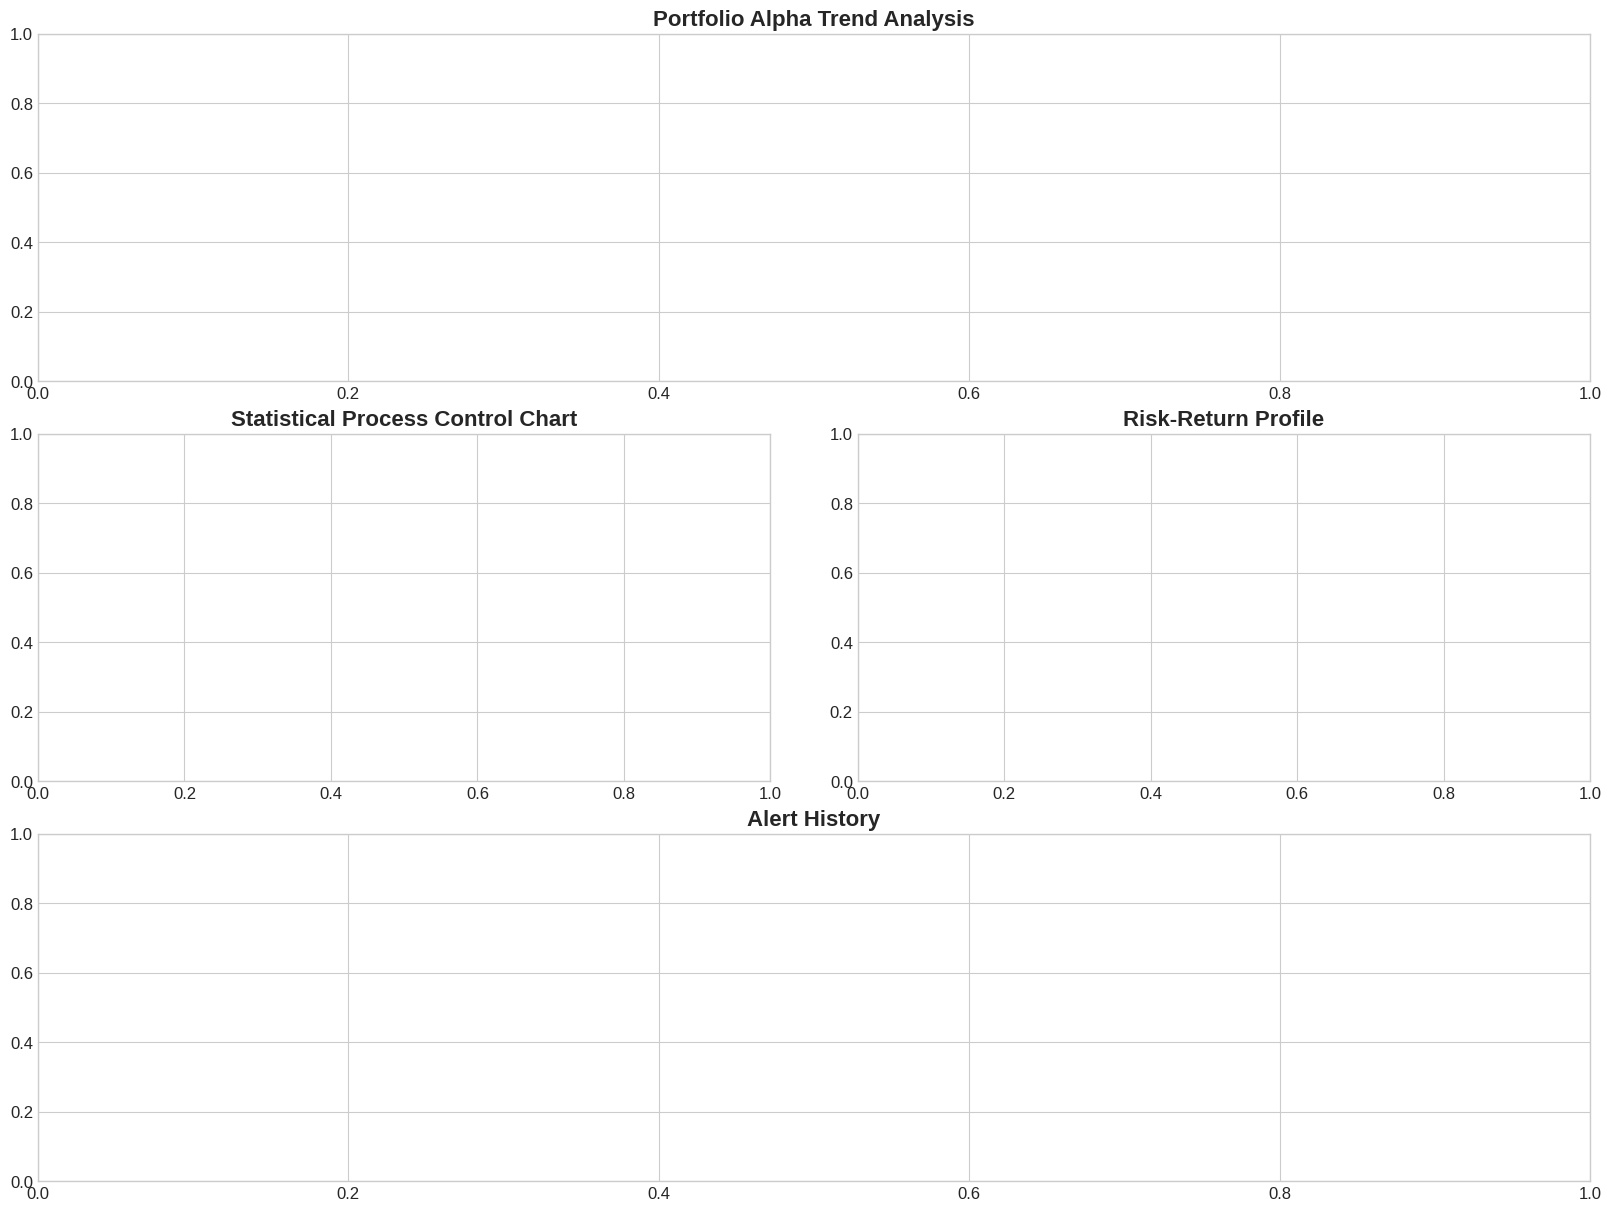

[18:29:25] Data fetched: Portfolio=289.8580307006836, Benchmark=621.6690063476562


/tmp/ipykernel_13833/3097340164.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, new_entry], ignore_index=True)


In [8]:
# Initialize and run the system
if __name__ == "__main__":
    monitor = AlphaDecayMonitor()
    monitor.show_dashboard()
    
    # For demonstration purposes - in production would connect to buttons
    monitor.start_monitoring()

In [9]:
print("System status:", monitor.running)
print("Thread alive:", monitor.thread.is_alive() if monitor.thread else "No thread")

System status: True
Thread alive: True
